In [19]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
pdr.get_data_yahoo = pdr.get_data_yahoo

In [20]:
#Start time and end time and importing the stock data

start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2016, 1, 1)

tickers = ['ADBE','MSFT']


df = yf.download(tickers, start, end)['Close']
print(df.head(5))
print(df.tail(5))

[*********************100%***********************]  2 of 2 completed

Ticker           ADBE       MSFT
Date                            
2010-01-04  37.090000  30.950001
2010-01-05  37.700001  30.959999
2010-01-06  37.619999  30.770000
2010-01-07  36.889999  30.450001
2010-01-08  36.689999  30.660000
Ticker           ADBE       MSFT
Date                            
2015-12-24  94.300003  55.669998
2015-12-28  94.199997  55.950001
2015-12-29  95.330002  56.549999
2015-12-30  95.279999  56.310001
2015-12-31  93.940002  55.480000


In [21]:
S1 = df['ADBE']
S2 = df['MSFT']

score, pvalue, some_value = coint(S1, S2)
print(f"Score : {score}")
print(f"pvalue : {pvalue}")

#pvalue is < 0.05 hence null hypothesis can be rejected.
# S1,S2 are cointegrated

#used this to check the best possible cointegration by changing start and end dates
#since more is co-integration higher is stationarity, chose the start, end year to be 2010-2016

Score : -3.9520490520340528
pvalue : 0.008395452724008485


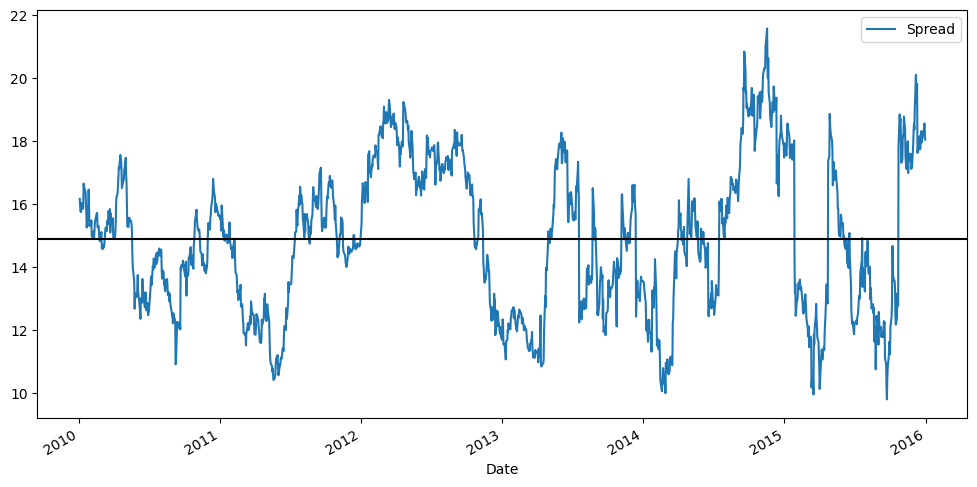

In [22]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ADBE']
b = results.params['ADBE']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.legend(['Spread']);

ratio = S1/S2

#plotting the spread(noise, considering S2-b*S1 to be stationary)

In [23]:
# Feature Engineering to train Random forest regressor to predict the ratio
#Features created
# mvg_avgs, lag(shifted versions), ROC, volatility, Spread, ratio

def generate_features(S1, S2, short_window=3, long_window=5):
    features = pd.DataFrame()
    
    features['S1'] = S1
    features['S2'] = S2
    # Moving Averages
    features['S1_mvg_avg_short'] = pd.Series(S1).rolling(short_window).mean()
    features['S2_mvg_avg_short'] = pd.Series(S2).rolling(short_window).mean()
    features['S1_mvg_avg_long'] = pd.Series(S1).rolling(long_window).mean()
    features['S2_mvg_avg_long'] = pd.Series(S2).rolling(long_window).mean()
    
    # Lag Features
    features['S1_lag_1'] = pd.Series(S1).shift(1)
    features['S2_lag_1'] = pd.Series(S2).shift(1)
    features['S1_lag_2'] = pd.Series(S1).shift(2)
    features['S2_lag_2'] = pd.Series(S2).shift(2)
    
    # Rate of Change
    features['S1_roc'] = pd.Series(S1).pct_change(periods=short_window)
    features['S2_roc'] = pd.Series(S2).pct_change(periods=short_window)
    
    # Rolling Standard Deviation (Volatility)
    features['S1_std'] = pd.Series(S1).rolling(short_window).std()
    features['S2_std'] = pd.Series(S2).rolling(short_window).std()
    
    # Spread and Ratio
    features['spread'] = pd.Series(S2) - b * pd.Series(S1)
    features['ratio'] = pd.Series(S2) / pd.Series(S1)
    
    # Rolling Correlation
    features['rolling_corr'] = pd.Series(S1).rolling(long_window).corr(pd.Series(S2))
    
    # Remove rows with NaN values (due to rolling calculations)
    features = features.dropna()
    
    return features

# Generate features
features = generate_features(S1, S2)

target = features['ratio']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate Model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 3.5213168416013664e-06


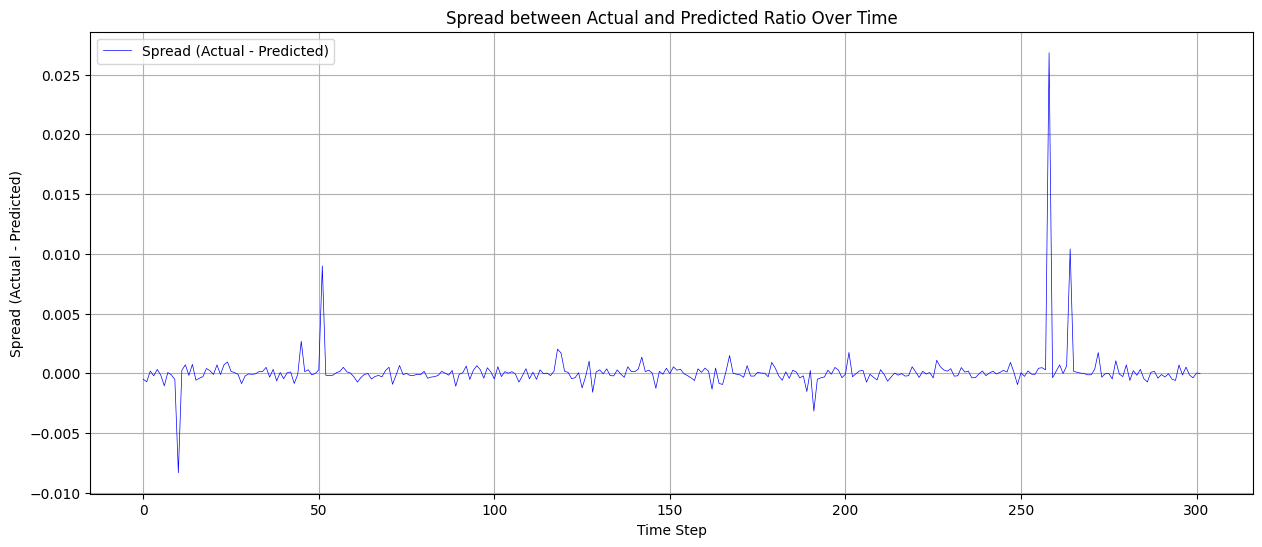

0.00012425225442067383


In [24]:
#Note this spread this different from spread defined in the prev block*
#The term spread is used since this is also a noise term considering y_test-y_pred is stationary

spread = y_test - y_pred

plt.figure(figsize=(15, 6))
plt.plot(spread.values, linestyle='-', color='b', label='Spread (Actual - Predicted)', linewidth=0.5)
plt.title('Spread between Actual and Predicted Ratio Over Time')
plt.xlabel('Time Step')
plt.ylabel('Spread (Actual - Predicted)')
plt.legend()
plt.grid(True)
plt.show()

print(spread.mean())

In [25]:
def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ', hence likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ', hence likely non-stationary.')

stationarity_test(spread)

p-value = 1.8870546888183692e-05, hence likely stationary.


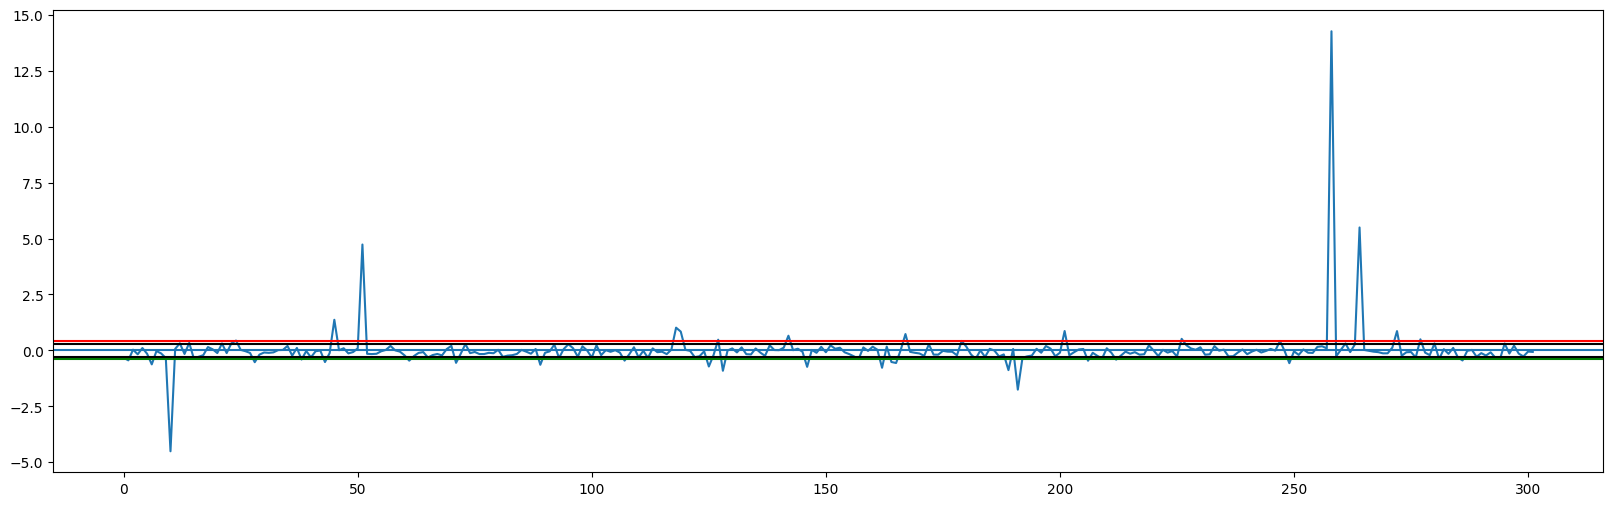

In [26]:
def zscore(series):
    return (series - np.mean(series)) / np.std(series)

zscore = zscore(spread.values)

#in the zone from black-black exit trade
#above red long
#below green short

plt.figure(figsize=(20, 6))
plt.plot(zscore)
plt.axhline(zscore.mean())
plt.axhline(0.4, color='red')
plt.axhline(-0.4, color='green')
plt.axhline(0.3, color='black')
plt.axhline(-0.3, color='black')
plt.show()


In [27]:
# Trade using a simple strategy
def trade(S1, S2, zscore, ratios):

    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        
        if zscore[i] < -0.4:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 2
            countS2 += 2*ratios[i]

        elif zscore[i] > 0.4:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 2
            countS2 -= 2*ratios[i]

        elif abs(zscore[i]) < 0.3:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0

    return money

trade(X_test['S1'], X_test['S2'], zscore, X_test['S1']/X_test['S2'])

343.749400750189